# Hyperbolic + multiprocessing

<div style="float:left;margin: 20px 20px 0 0;">Equation:
<br>
<img style="height:120px;" src="./pics/hyp-dif.png"></div>

<div style="float:left;margin-top:20px;">Solution:
<br>
<img style="height:30px;" src="./pics/hyp-solu.png"></div>

Coefficients:

In [1]:
from math import exp, pi, sin

a = 2**0.5
b = 4

min_x = 0
max_x = pi
step_x = pi/100
max_t = 1   
step_t = 1/100

## Numerical solution with mp

In [2]:
from multiprocessing import Process, Array

#for progress bar (don't mind the warning)---
from ipywidgets import FloatProgress
from IPython.display import display
#---

#explicit method (should be used in all labs as others can't be parallelized)
def explicit_fd(a, b,
                min_x, max_x, max_t, 
                step_x, step_t): 
    
    
    m = int(max_t / step_t) + 1
    n = int((max_x - min_x) / step_x) + 1
    
    #progress bar ---
    f = FloatProgress(min=0, max=m-2)
    display(f)
    #---
    
    u = [Array('d', [0.0 for i in range(n)]) for i in range(m)]

    init_2d_layer_func = get_init_2d_layer_func(a, b, step_t)

    for x in range(n):
        u[0][x] = 0  
        u[1][x] = init_2d_layer_func(min_x + x * step_x, 0) 

    A = 1 / (step_t ** 2) 
    B = ((a / step_x) ** 2 - b / (2 * step_x)) / A  
    C = (2 / step_t ** 2 - 2 * (a / step_x) ** 2) / A  
    D = ((a / step_x) ** 2 + b / (2 * step_x)) / A  
    
    def calc_elem(t, x, u, B, C, D):
        u[t][x] = (B * u[t - 1][x - 1] + C * u[t - 1][x] + D * u[t - 1][x + 1] - u[t - 2][x])
        
    def par(pn, mp, t, u, B, C, D):
        x = 1 + pn
        while x < n - 1:
            calc_elem(t, x, u, B, C, D)
            x += mp
    

    for t in range(2, m):    #multiprocessing
        mp = 4
        pool = []
        for pn in range(mp):
            pool.append(Process(target=par, args=(pn, mp, t, u, B, C, D,)))
            pool[-1].start()
            
        for i in pool:
            i.join()
                        
        u[t][0] = 0 
        u[t][n - 1] = 0 
        f.value += 1

    return u

In [3]:
def get_init_2d_layer_func(a, b, step_t): #feel free to get the rid of this
    
    def foo(x, prev_u):
        return prev_u + exp(-x) * sin(x) * step_t
                               
    return foo

In [4]:
u = explicit_fd(a, b,
                min_x, max_x, max_t, 
                step_x, step_t)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Solution plots

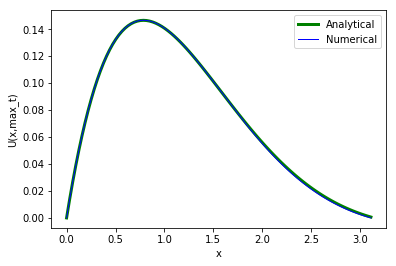

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, max_x, step_x)
u_an = [0.5 * exp(-x) * sin(x) * sin(2*max_t) for x in list(x)]
u_ch = u[-1]

#print(len(u_an), len(u_ch))

plt.plot(x,u_an,'g-', linewidth=3.0)
plt.plot(x,u_ch,'b-', linewidth=1.0)
plt.xlabel("x")
plt.ylabel("U(x,max_t)")
plt.legend(["Analytical","Numerical"])
plt.show()

## Absolute error plot

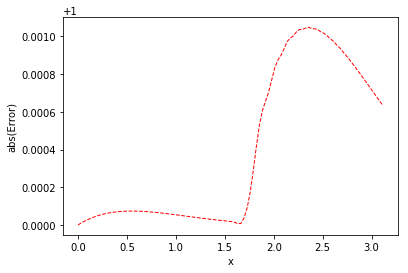

In [6]:
abs_er = list(map(lambda a, b: abs(a-b)+1, u_ch, u_an))

plt.plot(x, abs_er,'r--', linewidth=1.0)
plt.xlabel("x")
plt.ylabel("abs(Error)")
plt.show()